# Analisis Exploratorio Avanzado (EDA)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, List

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
df_clean = pd.read_csv('C:/Users/Usuario/Documents/prueba_pwc/predictive_salary_model/data/interim/dataset_cleaned.csv')

In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   373 non-null    int64  
 1   Age                  373 non-null    int64  
 2   Gender               373 non-null    object 
 3   Education Level      373 non-null    object 
 4   Job Title            373 non-null    object 
 5   Years of Experience  373 non-null    int64  
 6   Salary               373 non-null    float64
 7   Description          373 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 23.4+ KB


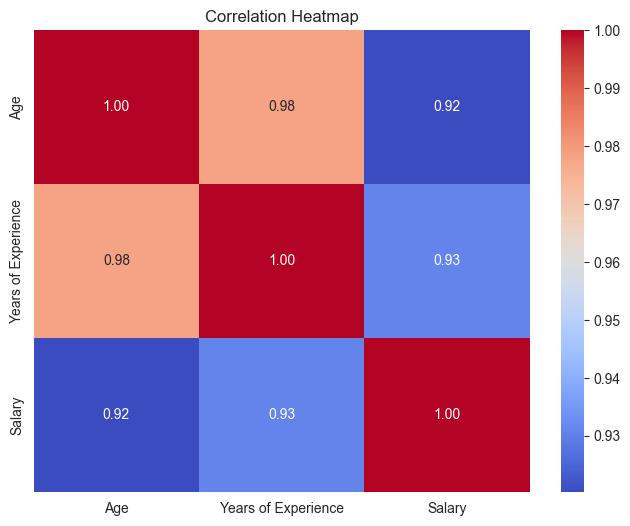

In [4]:
def plot_correlation_heatmap(df: pd.DataFrame, numerical_cols: List[str]) -> None:
    """
    Genera y muestra un heatmap de correlaciones entre columnas numéricas.

    :param df: DataFrame con los datos.
    :param numerical_cols: Lista de nombres de columnas numéricas a correlacionar.
    """
    corr_matrix = df[numerical_cols].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

num_cols = ["Age", "Years of Experience", "Salary"]
plot_correlation_heatmap(df_clean, num_cols)

Descripción

Se muestra la correlación entre Age, Years of Experience y Salary.
Observamos que Age y Years of Experience tienen una correlación muy alta (~0.98), y ambas se relacionan fuertemente con Salary (~0.92 y ~0.93, respectivamente).
Conclusiones

Este nivel de correlación sugiere multicolinealidad: en un modelo lineal, podría ocasionar inestabilidad en los coeficientes.
Las tres variables son muy relevantes para explicar la variación de Salary, pero tal vez sea suficiente con una sola de ellas (Age o Experience) en modelos lineales.
En algoritmos de árboles (RandomForest, XGBoost) esta redundancia impacta menos, pero es bueno tenerlo en mente.

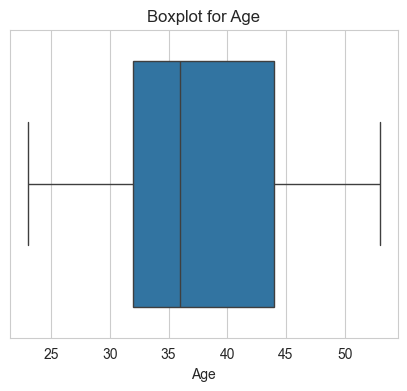

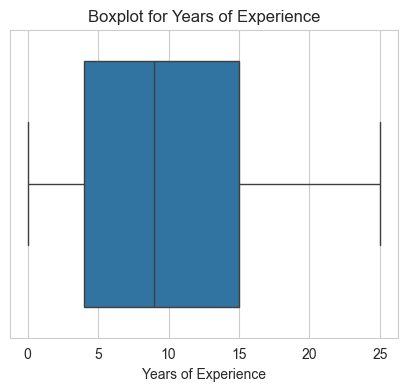

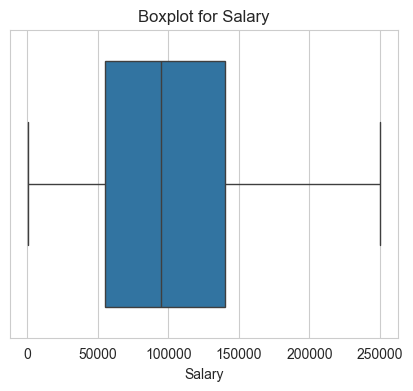

In [5]:
def plot_boxplots(df: pd.DataFrame, numerical_cols: List[str]) -> None:
    """
    Genera boxplots para cada columna numérica provista.
    
    :param df: DataFrame con los datos.
    :param numerical_cols: Lista de columnas numéricas para analizar.
    """
    for col in numerical_cols:
        plt.figure(figsize=(5, 4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot for {col}")
        plt.show()

plot_boxplots(df_clean, numerical_cols=num_cols)

Descripción

Cada boxplot revela la distribución y posibles outliers:
Age: Rango 23–53, mediana cerca de 36, sin outliers extremos.
Years of Experience: Rango 0–25, picos en 5–10 años y casos puntuales de 20+ años.
Salary: Rango ~350–250,000, con una mediana ~95,000 y valores altos que superan los 200,000.
Conclusiones

Age no presenta valores anómalos.
Experience puede tener saltos marcados (nuevos vs. muy experimentados).
Salary está sesgado a la derecha; hay pocos valores muy altos que podrían considerarse outliers en modelos lineales.

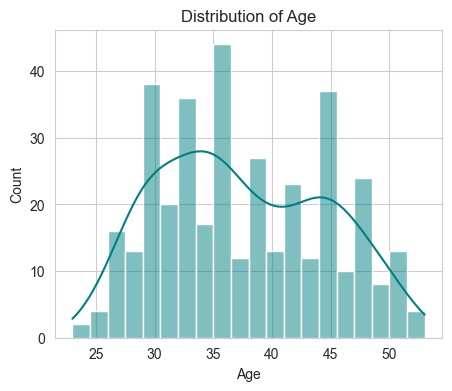

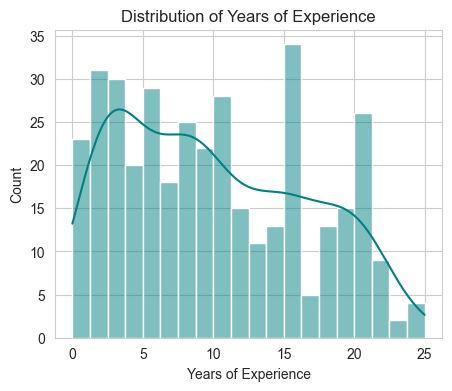

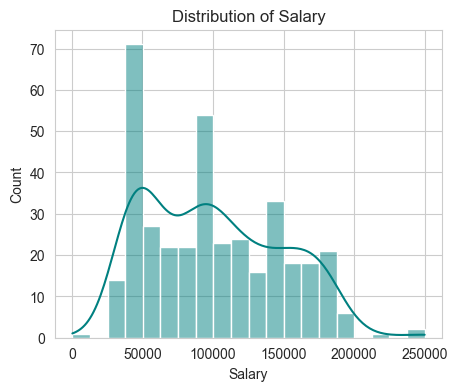

In [6]:

def plot_histograms(df: pd.DataFrame, numerical_cols: List[str]) -> None:
    """
    Genera histogramas para cada columna numérica provista.
    
    :param df: DataFrame con los datos.
    :param numerical_cols: Lista de columnas numéricas para analizar.
    """
    for col in numerical_cols:
        plt.figure(figsize=(5, 4))
        sns.histplot(df[col], kde=True, color="teal", bins=20)
        plt.title(f"Distribution of {col}")
        plt.show()

plot_histograms(df_clean, num_cols)

Descripción

Age: Aproximación casi normal, con mayor densidad entre 30–40 años.
Years of Experience: Distribución más irregular; un pico en los primeros años (0–5) y otro alrededor de ~15.
Salary: Marcado sesgo a la derecha (long tail); el grupo principal se ubica entre 50,000 y 120,000, pero también hay salarios de hasta 250,000.
Conclusiones

Con una distribución tan asimétrica en Salary, podrías aplicar una transformación log para métodos como Regresión Lineal.
Se confirma la idea de crear “bins” para Experience (junior, semi-senior, senior, etc.) dada su distribución no uniforme.

In [ ]:
bins = [0, 2, 7, 15, float('inf')]
labels = ["junior", "semi-senior", "senior", "expert"]

df_clean["experience_level"] = pd.cut(
    df_clean["Years of Experience"],
    bins=bins,
    labels=labels,
    include_lowest=True 
)

=== Mean Salary by Gender ===
Gender
Male       104172.797927
Female      96949.152542
Missing     83333.333333
Name: Salary, dtype: float64



C:\Users\Usuario\AppData\Local\Temp\ipykernel_22204\30573940.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=cat_col, y=salary_col, palette="viridis")


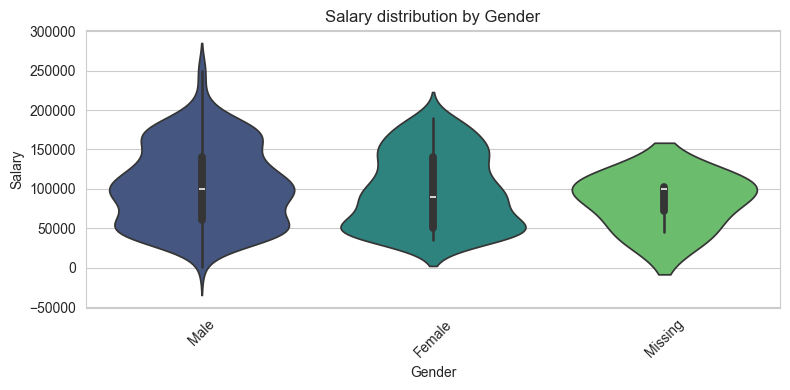

=== Mean Salary by Education Level ===
Education Level
PhD           157843.137255
Master's      129896.907216
Missing        96666.666667
Bachelor's     74663.738739
Name: Salary, dtype: float64



C:\Users\Usuario\AppData\Local\Temp\ipykernel_22204\30573940.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=cat_col, y=salary_col, palette="viridis")


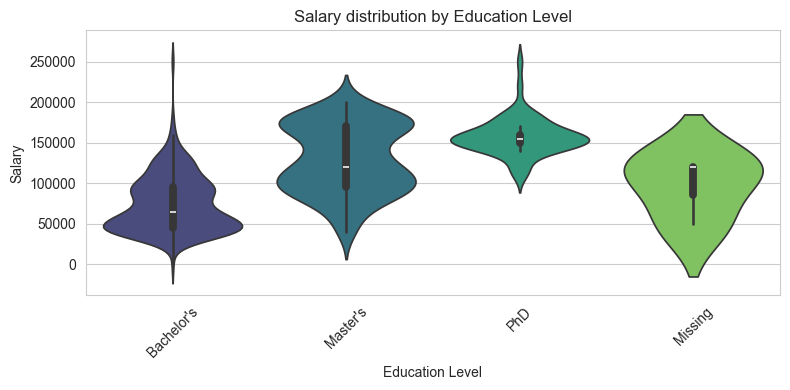

In [ ]:
def analyze_categorical_vs_salary(df: pd.DataFrame, cat_col: str, salary_col: str = "Salary") -> None:
    """
    Muestra el salario promedio y la distribución de salarios para cada categoría en cat_col.
    
    :param df: DataFrame con los datos.
    :param cat_col: Nombre de la columna categórica (e.g. 'Gender', 'Job Title').
    :param salary_col: Nombre de la columna que representa el salario.
    """
    mean_salary_by_cat = df.groupby(cat_col)[salary_col].mean().sort_values(ascending=False)
    print(f"=== Mean {salary_col} by {cat_col} ===\n{mean_salary_by_cat}\n")

    plt.figure(figsize=(8, 4))
    sns.violinplot(data=df, x=cat_col, y=salary_col, palette="viridis")
    plt.title(f"{salary_col} distribution by {cat_col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

categorical_columns = ["Gender", "Education Level"]
for cat in categorical_columns:
    analyze_categorical_vs_salary(df_clean, cat)

* Gender: El violinplot sugiere diferencias en la mediana y los valores extremos de salario (male vs. female vs. missing).
* Education Level: El salario tiende a ser mayor conforme aumenta la formación académica (PhD > Master’s > Bachelor’s), aunque con solapamientos entre categorías.

Implicaciones:
Ambas variables categóricas (Gender, Education Level) podrían tener poder predictivo.
El tratamiento de “Missing” en ambos casos (género o nivel educativo) es importante; conviene mantenerlo como una categoría adicional para no perder registros.
Se recomienda One-Hot Encoding u otras estrategias de codificación que reflejen el nivel formativo y el género en el modelado.

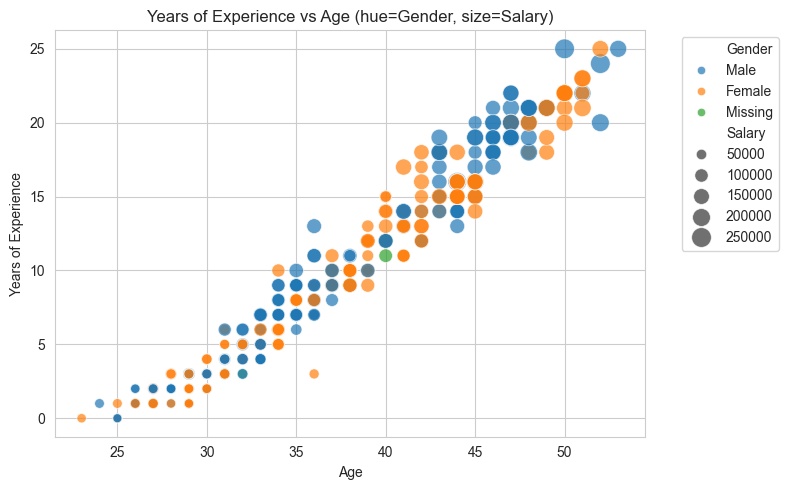

In [8]:
def scatter_experience_age_salary(df: pd.DataFrame,
                                  x_col: str = "Age",
                                  y_col: str = "Years of Experience",
                                  hue_col: Optional[str] = "Gender",
                                  size_col: Optional[str] = "Salary") -> None:
    """
    Crea un scatter plot analizando la interacción entre Edad, Años de Experiencia,
    y opcionalmente Salary como tamaño del punto y Gender como color.
    
    :param df: DataFrame con los datos.
    :param x_col: Variable eje X (por defecto, Age).
    :param y_col: Variable eje Y (por defecto, Years of Experience).
    :param hue_col: Columna para colorear puntos (por defecto, Gender).
    :param size_col: Columna para tamaño de los puntos (por defecto, Salary).
    """
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, size=size_col, sizes=(20, 200), alpha=0.7)
    plt.title(f"{y_col} vs {x_col} (hue={hue_col}, size={size_col})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

scatter_experience_age_salary(df_clean)

Descripción

Se aprecia una relación casi lineal: a mayor edad, mayor experiencia, lo que confirma la fuerte correlación numérica.
Los puntos grandes (representando salarios altos) suelen estar en la zona de mayor experiencia y/o edad, aunque hay excepciones.
El color sugiere que tanto hombres como mujeres se reparten a lo largo de toda la diagonal, con variaciones notables en el tamaño (Salary).
Conclusiones

Es un claro indicio de multicolinealidad entre edad y experiencia.
Un alto Salary suele coincidir con un mayor rango de experiencia/edad, pero también hay casos medianos o altos en rangos intermedios.
Podrías eliminar una de las dos variables en modelos lineales o crear una tercera (por ejemplo, Age - YearsExperience) si deseas capturar la idea de “edad de inicio profesional”.